In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir("../input/intel-image-classification"))
data_dir = "../input/intel-image-classification"
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['seg_train', 'seg_pred', 'seg_test']


In [2]:
!ls ../input/intel-image-classification

seg_pred  seg_test  seg_train


In [3]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [31]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001
epoch=20
# Other constants
input_size = 128*128
num_classes = 6

In [5]:
train_dir = data_dir + '/seg_train/seg_train'
test_dir = data_dir+ '/seg_test/seg_test'

#classes in dataset:
classes = os.listdir(train_dir)
classes

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

In [6]:
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_tfms = transforms.Compose([transforms.Resize((150,150)),
                         transforms.ToTensor(),
                         transforms.Normalize(*stats,inplace=True)])

# train_tfms = transforms.Compose([transforms.Resize((150,150)),
#                          transforms.ToTensor(),
#                          transforms.Normalize(*stats,inplace=True),
#                          transforms.ToPILImage(),
#                          transforms.RandomCrop(100, padding=4, padding_mode='reflect'),
#                          transforms.Resize((150,150)),
#                          transforms.RandomHorizontalFlip(), 
#                          transforms.ToTensor()])


test_tfms = transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor(), 
                         transforms.Normalize(*stats)])

ds = ImageFolder(train_dir, train_tfms)
test_ds = ImageFolder(test_dir, test_tfms)
ds_show = ImageFolder(train_dir,transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()]))

ds

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: ../input/intel-image-classification/seg_train/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
ds

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: ../input/intel-image-classification/seg_train/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

torch.Size([3, 150, 150]) 3
Label:  mountain (3)


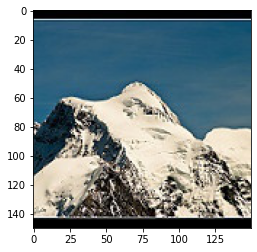

Label:  mountain (3)


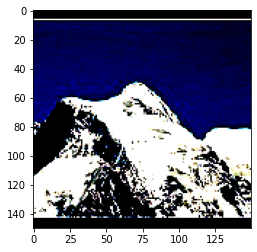

In [8]:
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
def show_example(img, label):
    print('Label: ', ds_show.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

img, label = ds_show[8555]
print(img.shape, label)

show_example(*ds_show[8555])
plt.show()
show_example(*ds[8555])
plt.show()

In [9]:
random_seed=2021;
torch.manual_seed(random_seed);
val_size=4000
train_size=len(ds)-val_size
train_ds,val_ds=random_split(ds,[train_size,val_size])

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size*2)

val_dl

In [10]:
# class Block(nn.Module):
#     def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
#         super(Block, self).__init__()
#         self.expansion = 1
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
#         self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
#         self.relu = nn.ReLU()
#         self.identity_downsample = identity_downsample

#     def forward(self, x):
#         identity = x
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         x = self.conv3(x)
#         x = self.bn3(x)

#         if self.identity_downsample is not None:
#             identity = self.identity_downsample(identity)

#         x += identity
#         x = self.relu(x)
#         return x

In [11]:
# class ResNet(nn.Module):
#     def __init__(self, block, image_channels, num_classes):
    
#         super(ResNet, self).__init__()
#         self.expansion = 1
  
#         layers = [3, 4, 6, 3]
#         self.in_channels = 64
#         self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         # ResNetLayers
#         self.layer1 = self.make_layers(block, layers[0], intermediate_channels=64, stride=1)
#         self.layer2 = self.make_layers(block, layers[1], intermediate_channels=128, stride=2)
#         self.layer3 = self.make_layers(block, layers[2], intermediate_channels=256, stride=2)
#         self.layer4 = self.make_layers(block, layers[3], intermediate_channels=512, stride=2)

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * self.expansion, num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.reshape(x.shape[0], -1)
#         x = self.fc(x)
#         return x

#     def make_layers(self, block, num_residual_blocks, intermediate_channels, stride):
#         layers = []
        
#         identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
#                                             nn.BatchNorm2d(intermediate_channels*self.expansion))
#         layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
#         self.in_channels = intermediate_channels * self.expansion # 256
#         for i in range(num_residual_blocks - 1):
#             layers.append(block(self.in_channels, intermediate_channels)) 
#         return nn.Sequential(*layers)

#     def training_step(self, batch):
#         images, labels = batch 
#         out = self(images)                  # Generate predictions
#         loss = F.cross_entropy(out, labels) # Calculate loss
#         return loss
    
#     def validation_step(self, batch):
#         images, labels = batch 
#         out = self(images)                    # Generate predictions
#         loss = F.cross_entropy(out, labels)   # Calculate loss
#         acc = accuracy(out, labels)           # Calculate accuracy
#         return {'val_loss': loss.detach(), 'val_acc': acc}
        
#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
#         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
#             epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
# def accuracy(outputs, labels):
#     _, preds = torch.max(outputs, dim=1)
#     return torch.tensor(torch.sum(preds == labels).item() / len(preds)) 

In [12]:
# def ResNet34(img_channels=3, num_classes=1000):
#     return ResNet(Block, img_channels, num_classes)

# model = ResNet34(num_classes=6)

# print(model)

In [39]:
class ImageModel(nn.Module):
    def __init__(self):   
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,16,3), #16x148x148
            nn.ReLU(),
            nn.Conv2d(16, 16, 3), #16x146x146
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #16x73x73

            nn.Conv2d(16, 32, 4), #32x70x70
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),  #32x68x68
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(32, 64, 3), #64x34x34
            nn.ReLU(),
            nn.Conv2d(64, 64, 3), #64x32x32
            nn.ReLU(),
            
            nn.Conv2d(64, 128, 3), #128x30x30
            nn.ReLU(),
            nn.Conv2d(128, 128, 3), #128x28x28
            nn.ReLU(),
            
            nn.Conv2d(128, 256, (3,3), padding='same'), #256x26x26
            nn.ReLU(),
            nn.Conv2d(256, 256, (3,3), padding='same'),#256x24x24
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #256x12x12
            
            
            nn.Conv2d(256, 512, 3), #512x10x10
            nn.ReLU(),
            nn.Conv2d(512, 512, 3),#512x8x8
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #512x4x4
            nn.Dropout(0.4),
            
            nn.Flatten(),
            
            nn.Linear(512*4*4,1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(64,6))
        
    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))    
   

model = ImageModel()
print(model)

ImageModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (17): ReLU()
    (18): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (19): ReLU()
    (20): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (21): ReLU()

In [40]:
device = torch.device('cuda')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

In [41]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [42]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, optimizer):
    history = []
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [43]:
model = to_device(model, device)

optimizer = torch.optim.Adam(model.parameters(),learning_rate)

reduce = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [44]:
evaluate(model, val_dl)

{'val_loss': 1.7949832677841187, 'val_acc': 0.17441406846046448}

In [45]:
history = fit(epoch, learning_rate, model, train_dl, val_dl, optimizer)

Epoch [0], train_loss: 1.5420, val_loss: 1.2854, val_acc: 0.4060
Epoch [1], train_loss: 1.2423, val_loss: 1.1888, val_acc: 0.4741
Epoch [2], train_loss: 1.1735, val_loss: 1.1458, val_acc: 0.5442
Epoch [3], train_loss: 1.0739, val_loss: 1.1100, val_acc: 0.5330
Epoch [4], train_loss: 1.0091, val_loss: 0.9638, val_acc: 0.6133
Epoch [5], train_loss: 0.9450, val_loss: 0.9479, val_acc: 0.6244
Epoch [6], train_loss: 0.8972, val_loss: 0.8898, val_acc: 0.6375
Epoch [7], train_loss: 0.8659, val_loss: 0.8266, val_acc: 0.6734
Epoch [8], train_loss: 0.8220, val_loss: 0.7795, val_acc: 0.7090
Epoch [9], train_loss: 0.7817, val_loss: 0.7683, val_acc: 0.7322
Epoch [10], train_loss: 0.7253, val_loss: 0.8201, val_acc: 0.7073
Epoch [11], train_loss: 0.7202, val_loss: 0.7530, val_acc: 0.7287
Epoch [12], train_loss: 0.6507, val_loss: 0.6643, val_acc: 0.7563
Epoch [13], train_loss: 0.6142, val_loss: 0.6999, val_acc: 0.7628
Epoch [14], train_loss: 0.6061, val_loss: 0.6328, val_acc: 0.7753
Epoch [15], train_lo

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return ds.classes[preds[0].item()]

In [ ]:
img, label = test_ds[1000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
cls_data = [[],[]]

for i in range(len(test_ds)):
    img, label = test_ds[i]
    prediction = predict_image(img, model)
    cls_data[0].append(ds.classes[label])
    cls_data[1].append(prediction)


labels = ['sea','forest','mountain','glacier','buildings','street']

    
from sklearn.metrics import classification_report

print(classification_report(cls_data[0], cls_data[1]))